In [1]:
import itertools
import os
import sys
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
from rich import print
from rich.progress import track
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
import hist
from hist import Hist

In [2]:
sys.path.insert(0, '../workflows/')

In [3]:
import SUEP_utils

In [4]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
hep.style.use(hep.style.CMS)

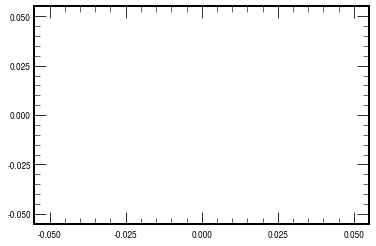

In [5]:
plt.plot();
hep.style.use(hep.style.CMS)
matplotlib.rcParams['figure.facecolor'] = 'white'

In [6]:
vector.register_awkward()

In [7]:
def get_dr_ring(dr, phi_c=0, eta_c=0, n_points=600):
    deta = np.linspace(-dr, +dr, n_points)
    dphi = np.sqrt(dr**2 - np.square(deta))
    deta = eta_c+np.concatenate((deta, deta[::-1]))
    dphi = phi_c+np.concatenate((dphi, -dphi[::-1]))
    return dphi, deta

def match_muons_to_jets(jets, muons, delta_r=0.4):
    """
    Will match muons to each jet after checking the delta_r between them.
    """
    dr_jets_to_muons = jets.metric_table(muons)
    muons_per_jet = ak.unzip(ak.cartesian([jets, muons], nested=True))[1]
    muons_per_jet = muons_per_jet[dr_jets_to_muons < delta_r]
    return muons_per_jet

def mini_iso_cone_size(muons):
    """
    Calculate the miniPFRelIso_all cone size for each muon.
    This is 0.2 for muons with pt <= 50, 0.05 for muons with pt >= 200, and 10/pt for muons with 50 < pt < 200.
    """
    return ak.where(
        muons.pt <= 50, 
        0.2, 
        ak.where(muons.pt >= 200, 0.05, 10 / muons.pt)
    )


def muon_iso_sub_muons(muons_for_iso, muons_all):
    """
    Subtract the isolation of other muons from the isolation of the muon.
    """
    dR_muons = ak.fill_none(muons_for_iso.metric_table(muons_all), [], axis=0)
    muons_for_iso_broadcasted, muons_in_cone = ak.unzip(ak.cartesian([muons_for_iso, muons_all], nested=True))
    cone_size = mini_iso_cone_size(muons_for_iso_broadcasted)
    muons_in_cone = muons_in_cone[dR_muons < cone_size]
    muon_contributions = (
        ak.sum(muons_in_cone.pt, axis=-1) - muons_for_iso.pt
    ) / muons_for_iso.pt
    return muons_for_iso.miniPFRelIso_all - muon_contributions

In [8]:
# Create directory
output_path = "fake_rate_plots/event_displays/inverse_cut/"
if not os.path.exists(output_path):
#     if not os.path.exists(output_path):
#         os.makedirs(output_path)
#     if not os.path.exists(output_path + "signal"):
#         os.makedirs(output_path + "signal")
    if not os.path.exists(output_path + "QCD"):
        os.makedirs(output_path + "QCD")

Processing QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8 - 1

Found 5 event(s)

Muons:

phi: [2.09, -0.81, -0.778, -0.857]

eta: [-0.817, 2.06, 1.94, 1.97]

pt: [23.6, 16.1, 6.31, 5.9]

miniPFRelIso_all: [0.507, 0.215, 0.55, 0.421]

pfRelIso03_all: [0.614, 0.215, 0.55, 0.952]

pfRelIso04_all: [0.827, 0.349, 0.89, 0.952]

For jet with 3 muons:

pt: [16.11, 6.31, 5.90]

miniPFRelIso_all: [0.22, 0.55, 0.42]

iso (muon sub/ted): [-0.54, -2.94, -3.38]

muon contribution: [0.76, 3.49, 3.80]

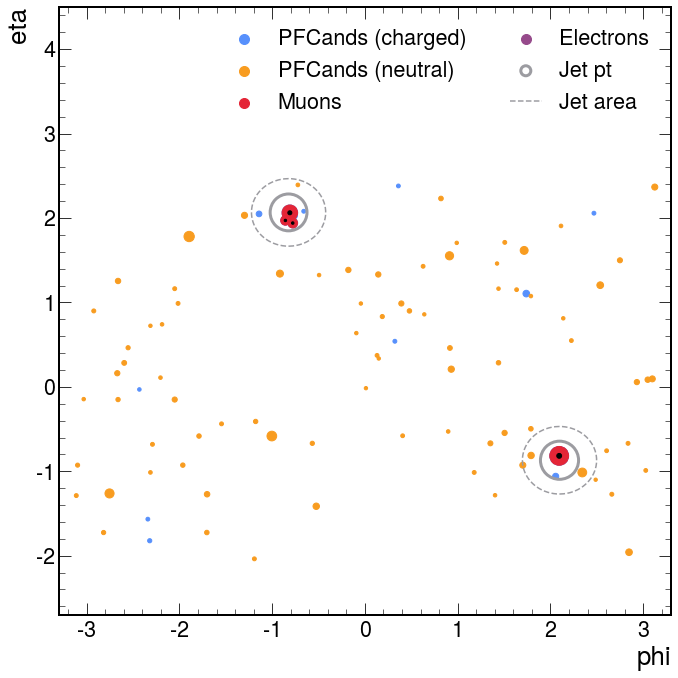

Muons:

phi: [2.91, 2.9, 2.37, 2.91]

eta: [2.3, 2.36, 2.09, 2.21]

pt: [11.1, 7.99, 5.87, 3.08]

miniPFRelIso_all: [1.24, 0, 0, 0]

pfRelIso03_all: [1.24, 1.72, 0.419, 4.89]

pfRelIso04_all: [1.58, 2.02, 0.463, 4.89]

For jet with 3 muons:

pt: [11.08, 7.99, 3.08]

miniPFRelIso_all: [1.24, 0.00, 0.00]

iso (muon sub/ted): [0.24, -1.77, -6.20]

muon contribution: [1.00, 1.77, 6.20]

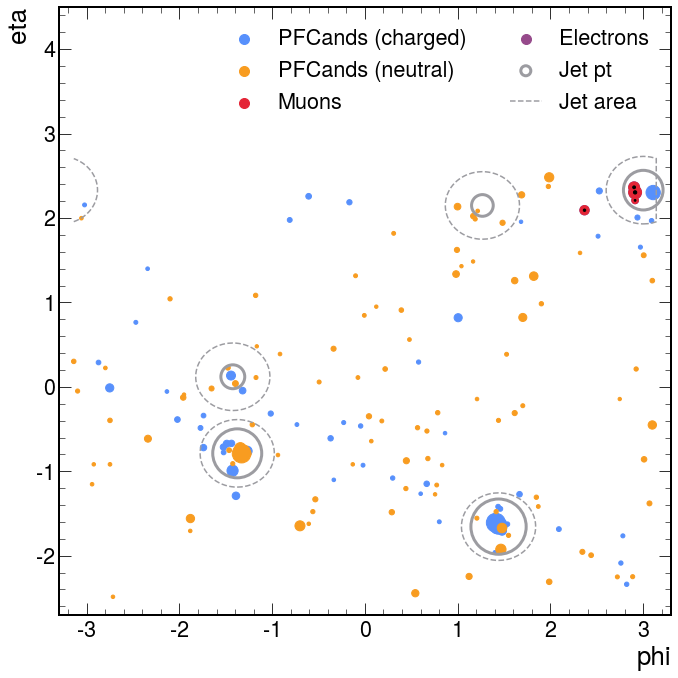

Muons:

phi: [-0.388, -0.783, -0.761, -0.874]

eta: [1.04, 1.89, 1.64, 1.82]

pt: [9.45, 7.71, 6.52, 5.74]

miniPFRelIso_all: [0, 0, 0, 0.0441]

pfRelIso03_all: [0.261, 0.0328, 0.216, 0.0441]

pfRelIso04_all: [0.528, 0.0328, 0.216, 0.0441]

For jet with 3 muons:

pt: [7.71, 6.52, 5.74]

miniPFRelIso_all: [0.00, 0.00, 0.04]

iso (muon sub/ted): [-0.74, 0.00, -1.30]

muon contribution: [1.59, 2.06, 2.48]

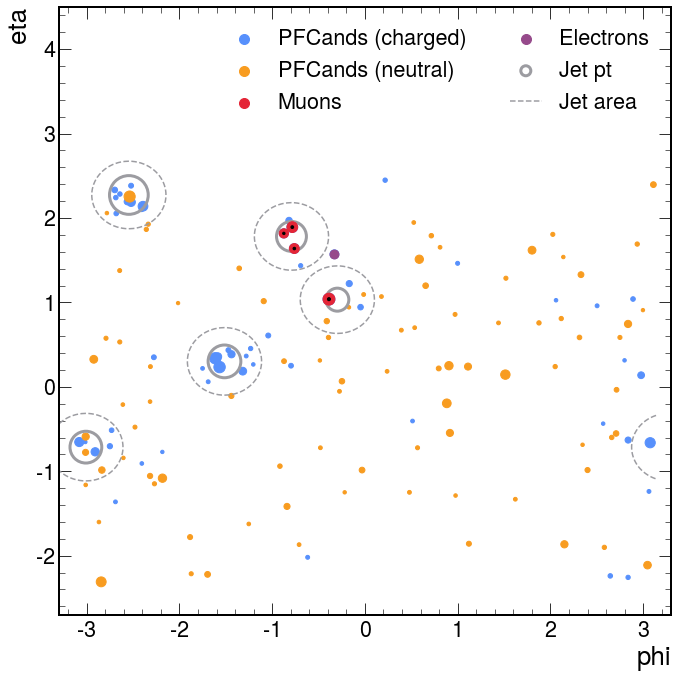

Muons:

phi: [-0.33, -2.38, -0.39, -0.255]

eta: [0.256, -0.914, 0.0735, 0.313]

pt: [9.45, 7.92, 5.79, 5.48]

miniPFRelIso_all: [0.218, 4.97, 0.434, 0.439]

pfRelIso03_all: [0.706, 5.67, 0.79, 0.76]

pfRelIso04_all: [0.816, 6.13, 1.15, 1.27]

For jet with 3 muons:

pt: [9.45, 5.79, 5.48]

miniPFRelIso_all: [0.22, 0.43, 0.44]

iso (muon sub/ted): [-0.97, -1.20, -1.29]

muon contribution: [1.19, 2.58, 2.78]

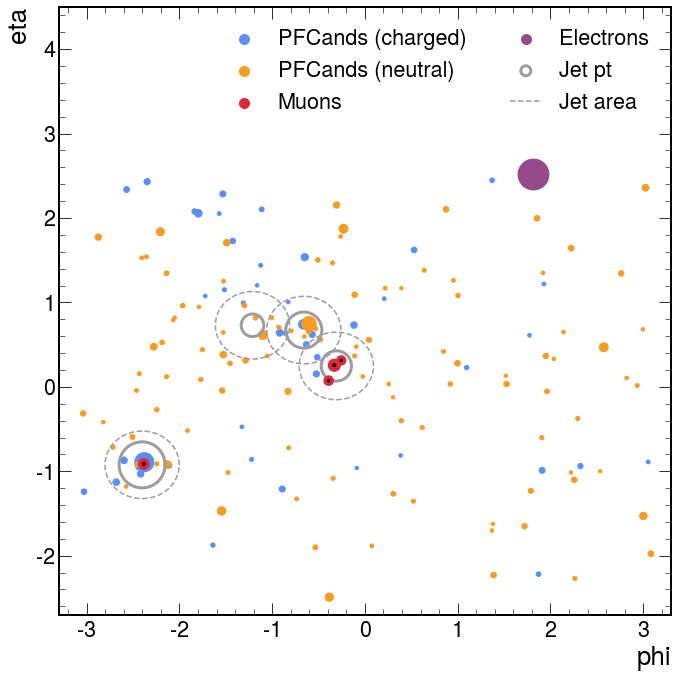

Muons:

phi: [-0.729, 2.39, 2.35, 2.34]

eta: [-0.626, 0.988, 0.938, 0.923]

pt: [20, 13.5, 13.4, 6.25]

miniPFRelIso_all: [0.667, 0.766, 0.769, 1.65]

pfRelIso03_all: [1.58, 0.937, 0.94, 1.82]

pfRelIso04_all: [1.72, 1.09, 1.13, 2.54]

For jet with 3 muons:

pt: [13.49, 13.44, 6.25]

miniPFRelIso_all: [0.77, 0.77, 1.65]

iso (muon sub/ted): [-0.69, -0.70, -2.66]

muon contribution: [1.46, 1.47, 4.31]

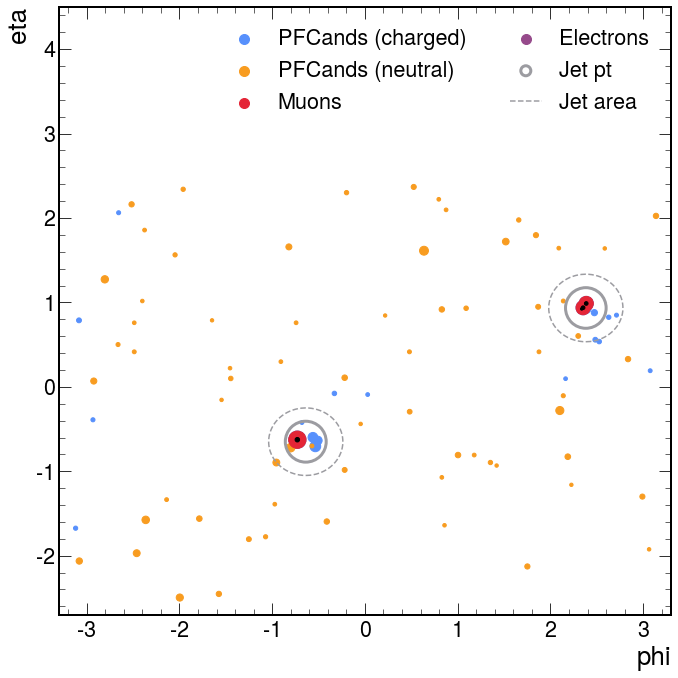

In [33]:
xrd_path = 'root://cmseos.fnal.gov//store/user'

#signal = "GluGluToSUEP_T0p35_TuneCP5_13TeV_pythia8"
qcd = "QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8"

# signal_datasets = [
#     "GluGluToSUEP_T0p35_TuneCP5_13TeV_pythia8",
#     "GluGluToSUEP_T2p00_TuneCP5_13TeV_pythia8",
#     "GluGluToSUEP_T32p00_TuneCP5_13TeV_pythia8",
# ]
# signal_labels = [
#     "SUEP_mS125.000_mPhi1.400_T0.350_modehadronic",
#     "SUEP_mS125.000_mPhi2.000_T2.000_modehadronic",
#     "SUEP_mS125.000_mPhi8.000_T32.000_modehadronic",
# ]
qcd_datasets = [
#     ("QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
    ("QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 2),
#     ("QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 2),
#     ("QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 8),
#     ("QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 3),
]

for dataset, nFiles in qcd_datasets:
    for iFile in range(1, nFiles+1):
        label = dataset
        print(f"Processing {dataset} - {iFile}")
        file = nanoevents.NanoEventsFactory.from_root(
            f"{xrd_path}/chpapage/SUEPNano_Jul2024_merged/{dataset}/skim_{iFile}.root",
            schemaclass=nanoevents.NanoAODSchema,
        )
        events = file.events()

        muons = events.Muon
        events, muons = events[ak.num(muons) > 0], muons[ak.num(muons) > 0]
        clean_muons = (
            (events.Muon.mediumId)
            & (events.Muon.pt > 3)
            & (abs(events.Muon.eta) < 2.4)
            & (abs(events.Muon.dxy) <= 0.02) 
            & (abs(events.Muon.dz) <= 0.1)
        )
        muons = muons[clean_muons]

#         # Remove muons that are too close to other muons
#         dr_table = muons.metric_table(muons)
#         muons = muons[ak.sum(dr_table < 0.8, axis=-1) == 1]

#         select_by_muons_high = ak.num(muons, axis=-1) == 5
#         events = events[select_by_muons_high]
#         muons = muons[select_by_muons_high]

#         # tight selection
#         nTight = ak.sum(muons.miniPFRelIso_all < 1, axis=-1)
#         nInverse = ak.sum(muons.miniPFRelIso_all >= 1, axis=-1)
#         events = events[(nInverse == 4) & (nTight == 1)]
#         muons = muons[(nInverse == 4) & (nTight == 1)]


        # Select using lumiblock and event number
        events_to_show = []
        events_to_show_details = [
            # this is for 50to80 and for 3T0I, nMuon_in_jet=3 & nMuon=4
            {'lumi': 12392, 'event': 516093561},
            {'lumi': 29947, 'event': 1247254014},
            {'lumi': 9965, 'event': 415037141},
            {'lumi': 10268, 'event': 427642163},
            {'lumi': 11578, 'event': 482202857},
        ]
#         events_to_show_details = [
#             # this is for 170to300 and for 3T0I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 44156, 'event': 647192127},
#             {'lumi': 26612, 'event': 390037638},
#             {'lumi': 58983, 'event': 864500185},
#         ]
#         events_to_show_details = [
#             # this is for 50to80 and for 0T3I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 21028, 'event': 875791039},
#             {"lumi": 22448, 'event': 934941054},
#             {'lumi': 20858, 'event': 868694760},
#         ]
#         events_to_show_details = [
#             # this is for 170to300 and for 3T0I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 24810, 'event': 363628374}
#         ]
#         events_to_show_details = [
#             # this is for 120to170 and for 0T3I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 26414, 'event': 512288813},
#             {'lumi': 35742, 'event': 693215824},
#             {'lumi': 739, 'event': 14326027},
#             {'lumi': 9136, 'event': 177185660},
#             {'lumi': 15781, 'event': 306071708},
#             {'lumi': 29556, 'event': 573235220},
#         ]
    
        for evt in events_to_show_details:
            selection = (events.luminosityBlock == evt['lumi']) & (events.event == evt['event'])
            if ak.any(selection):
                events_to_show.append(
                    ak.argmax(selection)
                )
        events = events[events_to_show]
        muons = muons[events_to_show]
    
        if len(events) == 0:
            continue
        else:
            print(f"Found {len(events)} event(s)")

        Jets = events.Jet[(events.Jet.pt > 15) & (abs(events.Jet.eta) < 2.5)]

        Cands = ak.zip(
            {
                "pt": events.PFCands.pt,
                "eta": events.PFCands.eta,
                "phi": events.PFCands.phi,
                "mass": events.PFCands.mass,
                "charge": events.PFCands.charge,
            },
            with_name="Momentum4D",
        )
        cut = (
            (events.PFCands.fromPV > 1)
            & (events.PFCands.pt >= 0.75)
            & (abs(events.PFCands.eta) <= 2.5)
            & (abs(events.PFCands.dz) < 10)
            & (events.PFCands.dzErr < 0.05)
        )
        Cleaned_cands = Cands[cut]
        charged_pfcands = Cleaned_cands[abs(Cleaned_cands.charge) > 0]
        neutral_pfcands = Cleaned_cands[Cleaned_cands.charge == 0]

        # Get the muons per jet
        muons_per_jet = match_muons_to_jets(Jets, muons, delta_r=0.4)
        muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=-1) == 3]
        muons_ = muons[ak.num(muons_per_jet, axis=1) > 0]
        muons_per_jet = muons_per_jet[ak.num(muons_per_jet, axis=1) > 0]
        muon_0 = muons_per_jet[:, :, 0]
        muon_1 = muons_per_jet[:, :, 1]
        muon_2 = muons_per_jet[:, :, 2]
        muon_0_iso_sub_muons = muon_iso_sub_muons(muon_0, muons_)
        muon_1_iso_sub_muons = muon_iso_sub_muons(muon_1, muons_)
        muon_2_iso_sub_muons = muon_iso_sub_muons(muon_2, muons_)
        
    #     scalar = events.GenPart[(events.GenPart.pdgId==25) & (events.GenPart.status==62)]
    #     scalar_collection = ak.zip(
    #         {
    #             "px": scalar.px,
    #             "py": scalar.py,
    #             "pz": scalar.pz,
    #             "mass": scalar.mass,
    #         },
    #         with_name="Momentum4D",
    #     )
    #     scalar_collection = ak.flatten(scalar_collection)

    #     ak8jets, ak8jetws_cluster = SUEP_utils.FastJetReclustering(
    #         ak.packed(Cleaned_cands), r=0.8, min_pt=10
    #     )

        iEvt = 0
        nPrint = 10
        if len(events) < nPrint:
            nPrint = len(events)
        for iEvt in range(nPrint):
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            fig.set_facecolor("w")
            ax.scatter(charged_pfcands[iEvt].phi, charged_pfcands[iEvt].eta, s=15*charged_pfcands[iEvt].pt)
            ax.scatter(neutral_pfcands[iEvt].phi, neutral_pfcands[iEvt].eta, s=15*neutral_pfcands[iEvt].pt)
            ax.scatter(muons[iEvt].phi, muons[iEvt].eta, s=15*muons[iEvt].pt, zorder=10,)
            ax.scatter(muons[iEvt].phi, muons[iEvt].eta, s=muons[iEvt].pt, zorder=15, color='black')
            ax.scatter(events.Electron[iEvt].phi, events.Electron[iEvt].eta, s=15*events.Electron[iEvt].pt)
            #ax.scatter(scalar[iEvt].phi, scalar[iEvt].eta, s=30*scalar[iEvt].pt, marker='x')
            ax.scatter(
                Jets[iEvt].phi, Jets[iEvt].eta, s=30*Jets[iEvt].pt,
                facecolors='none', edgecolors='C4', lw=3
            )

            print("Muons:")
            print("\tphi:", muons[iEvt].phi)
            print("\teta:", muons[iEvt].eta)
            print("\tpt:", muons[iEvt].pt)
            print("\tminiPFRelIso_all:", muons[iEvt].miniPFRelIso_all)
            print("\tpfRelIso03_all:", muons[iEvt].pfRelIso03_all)
            print("\tpfRelIso04_all:", muons[iEvt].pfRelIso04_all)

            print("For jet with 3 muons:")
            print(
                "\tpt:", 
                f"[{muon_0[iEvt].pt[0]:.2f}, "
                f"{muon_1[iEvt].pt[0]:.2f}, "
                f"{muon_2[iEvt].pt[0]:.2f}]"
            )
            print(
                "\tminiPFRelIso_all:", 
                f"[{muon_0[iEvt].miniPFRelIso_all[0]:.2f}, "
                f"{muon_1[iEvt].miniPFRelIso_all[0]:.2f}, "
                f"{muon_2[iEvt].miniPFRelIso_all[0]:.2f}]"
            )
            print(
                "\tiso (muon sub/ted): "
                f"[{muon_0_iso_sub_muons[iEvt][0]:.2f}, "
                f"{muon_1_iso_sub_muons[iEvt][0]:.2f}, "
                f"{muon_2_iso_sub_muons[iEvt][0]:.2f}]"
            )
            print(
                "\tmuon contribution: "
                f"[{(muon_1[iEvt].pt[0]+muon_2[iEvt].pt[0])/muon_0[iEvt].pt[0]:.2f}, "
                f"{(muon_0[iEvt].pt[0]+muon_2[iEvt].pt[0])/muon_1[iEvt].pt[0]:.2f}, "
                f"{(muon_0[iEvt].pt[0]+muon_1[iEvt].pt[0])/muon_2[iEvt].pt[0]:.2f}]"
            )
            
    #         print("AK8Jets:")
    #         print("\tphi:", ak8jets[iEvt].phi)
    #         print("\teta:", ak8jets[iEvt].eta)
    #         print("\tpt:", ak8jets[iEvt].pt)

            for jet in Jets[iEvt]:
                phis, etas = get_dr_ring(0.4, jet.phi, jet.eta)
                ax.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C4', linestyle='--')
                ax.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C4', linestyle='--')
                ax.plot(phis[phis<math.pi], etas[phis<math.pi], color='C4', linestyle='--')

#             ax.text(
#                 -3, -4.5, 
#                 "Cuts (applied with the following order):\n"
#                 "    Trigger && muon cleaning && muon dr distance>0.8 &&\n"
#                 "    nMuon=5 && tight sel. muon_miniPFRelIso_all<1 &&\n"
#                 "    nMuon_inverse=4 && nMuon_tight=1",
#                 size=20
#             )

            ax.set_xlim(-3.3, 3.3)
            ax.set_ylim(-2.7, 4.5)
            ax.set_xlabel('phi')
            ax.set_ylabel('eta')
            ax.scatter([], [], s=100, color='C0', label="PFCands (charged)")
            ax.scatter([], [], s=100, color='C1', label="PFCands (neutral)")
            ax.scatter([], [], s=100, color='C2', label="Muons")
            ax.scatter([], [], s=100, color='C3', label="Electrons")
            ax.scatter([], [], s=100, color='C4', facecolors='none', edgecolors='C4', lw=3, label="Jet pt")
            ax.plot([], [], color='C4', linestyle='--', label="Jet area")
            ax.legend(ncol=2, loc=1)
            fig.tight_layout()
            fig.savefig(f"{output_path}/{label}_iFile{iFile}_iEvt{iEvt}.pdf")
            plt.show()

In [1]:
iEvt0 = len(events)
print(iEvt0)

NameError: name 'events' is not defined

In [66]:
# Deploy plots
!tar -cf event_displays.tar kinematics_plots/event_displays
!xrdcp -f event_displays.tar root://eosuser.cern.ch//eos/user/c/chpapage/

[4.121MB/4.121MB][100%][==================================================][1.374MB/s]  


## Same but for the jet

Processing QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8 - 1

Found 3 event(s)

Muons:

phi: [1.97, 0.0302, 0.0158, -2.37, 0.0253]

eta: [0.447, -2.2, -2.15, 0.143, -2.39]

pt: [14.7, 10.2, 4.94, 4.91, 3.08]

miniPFRelIso_all: [0.85, 3.54, 7.3, 4.8, 12.6]

pfRelIso03_all: [1.15, 3.58, 7.96, 5.95, 12.8]

pfRelIso04_all: [1.1, 4.08, 8.17, 6.66, 13.1]

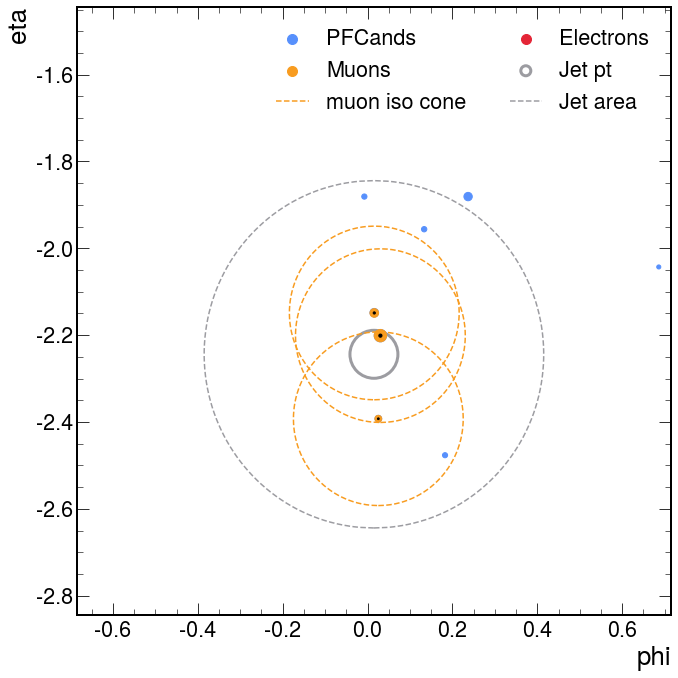

Muons:

phi: [-2.43, 1.66, 1.55, 1.66, -0.27]

eta: [-1.39, -0.676, -0.619, -0.654, -1.9]

pt: [10.9, 8.4, 7.2, 5.51, 3.81]

miniPFRelIso_all: [0, 6.14, 7.09, 9.35, 0.737]

pfRelIso03_all: [0, 6.28, 7.19, 9.56, 0.642]

pfRelIso04_all: [0, 6.26, 7.57, 9.54, 0.642]

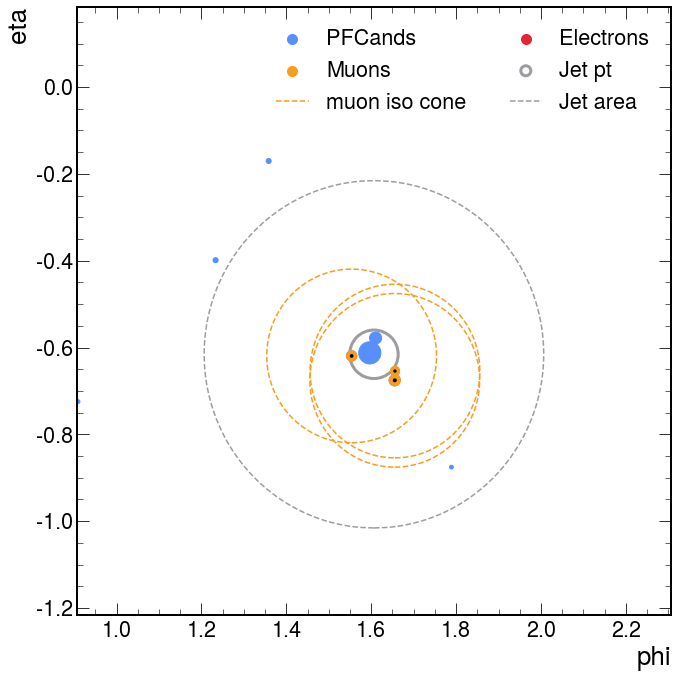

Muons:

phi: [-3.13, 3.12, -0.282, -0.427, -0.576]

eta: [-0.131, -0.424, 1.71, 1.61, 1.66]

pt: [6.26, 6.1, 5.03, 4.25, 3.26]

miniPFRelIso_all: [4.31, 5.34, 2.18, 4.14, 3.17]

pfRelIso03_all: [6.47, 5.16, 3.2, 3.45, 4.5]

pfRelIso04_all: [7.41, 5.22, 2.91, 3.55, 4.5]

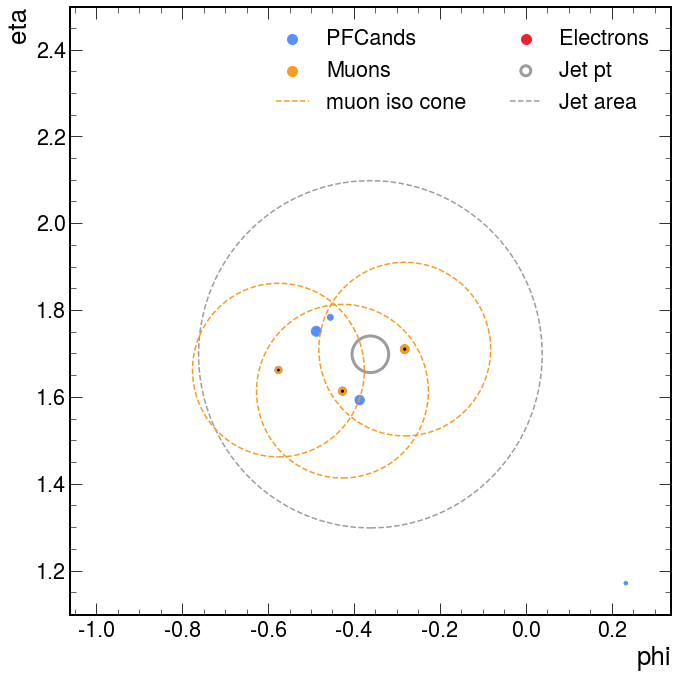

In [22]:
xrd_path = 'root://cmseos.fnal.gov//store/user'

#signal = "GluGluToSUEP_T0p35_TuneCP5_13TeV_pythia8"
qcd = "QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8"

# signal_datasets = [
#     "GluGluToSUEP_T0p35_TuneCP5_13TeV_pythia8",
#     "GluGluToSUEP_T2p00_TuneCP5_13TeV_pythia8",
#     "GluGluToSUEP_T32p00_TuneCP5_13TeV_pythia8",
# ]
# signal_labels = [
#     "SUEP_mS125.000_mPhi1.400_T0.350_modehadronic",
#     "SUEP_mS125.000_mPhi2.000_T2.000_modehadronic",
#     "SUEP_mS125.000_mPhi8.000_T32.000_modehadronic",
# ]
qcd_datasets = [
#     ("QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
    ("QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 1),
#     ("QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 2),
#     ("QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 2),
#     ("QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 4),
#     ("QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 8),
#     ("QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8", 3),
]

for dataset, nFiles in qcd_datasets:
    for iFile in range(1, nFiles+1):
        label = dataset
        print(f"Processing {dataset} - {iFile}")
        file = nanoevents.NanoEventsFactory.from_root(
            f"{xrd_path}/chpapage/SUEPNano_Jul2024_merged/{dataset}/skim_{iFile}.root",
            schemaclass=nanoevents.NanoAODSchema,
        )
        events = file.events()

        muons = events.Muon
        events, muons = events[ak.num(muons) > 0], muons[ak.num(muons) > 0]
        clean_muons = (
            (events.Muon.mediumId)
            & (events.Muon.pt > 3)
            & (abs(events.Muon.eta) < 2.4)
            & (abs(events.Muon.dxy) <= 0.02) 
            & (abs(events.Muon.dz) <= 0.1)
        )
        muons = muons[clean_muons]

        # Select using lumiblock and event number
        events_to_show = []
#         events_to_show_details = [
#             # this is for 50to80 and for 3T0I, nMuon_in_jet=3 & nMuon=4
#             {'lumi': 12392, 'event': 516093561},
#             {'lumi': 29947, 'event': 1247254014},
#             {'lumi': 9965, 'event': 415037141},
#             {'lumi': 10268, 'event': 427642163},
#             {'lumi': 11578, 'event': 482202857},
#         ]
#         events_to_show_details = [
#             # this is for 170to300 and for 3T0I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 24810, 'event': 363628374}
#         ]
#         events_to_show_details = [
#             # this is for 50to80 and for 0T3I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 21028, 'event': 875791039},
#             {"lumi": 22448, 'event': 934941054},
#             {'lumi': 20858, 'event': 868694760},
#         ]
#         events_to_show_details = [
#             # this is for 120to170 and for 0T3I, nMuon_in_jet=3 & nMuon=5
#             {'lumi': 26414, 'event': 512288813},
#             {'lumi': 35742, 'event': 693215824},
#             {'lumi': 739, 'event': 14326027},
#             {'lumi': 9136, 'event': 177185660},
#             {'lumi': 15781, 'event': 306071708},
#             {'lumi': 29556, 'event': 573235220},
#         ]
    
        for evt in events_to_show_details:
            selection = (events.luminosityBlock == evt['lumi']) & (events.event == evt['event'])
            if ak.any(selection):
                events_to_show.append(
                    ak.argmax(selection)
                )
        events = events[events_to_show]
        muons = muons[events_to_show]
    
        if len(events) == 0:
            continue
        else:
            print(f"Found {len(events)} event(s)")

        Jets = events.Jet[abs(events.Jet.eta) < 2.5]
        
        jets_with_muons = ak.firsts(
            Jets[ak.sum(ak.values_astype(Jets.metric_table(muons) < 0.4, np.int32), axis=-1) == 3]
        )

        Cands = ak.zip(
            {
                "pt": events.PFCands.trkPt,
                "eta": events.PFCands.trkEta,
                "phi": events.PFCands.trkPhi,
                "mass": events.PFCands.mass,
                "charge": events.PFCands.charge,
            },
            with_name="Momentum4D",
        )
        cut = (
            (events.PFCands.fromPV > 1)
            & (events.PFCands.trkPt >= 0.75)
            & (abs(events.PFCands.trkEta) <= 2.5)
            & (abs(events.PFCands.dz) < 10)
            & (events.PFCands.dzErr < 0.05)
        )
        Cleaned_cands = Cands[cut]
        
        iEvt = 0
        nPrint = 10
        if len(events) < nPrint:
            nPrint = len(events)
        for iEvt in range(nPrint):
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            fig.set_facecolor("w")
            ax.scatter(Cleaned_cands[iEvt].phi, Cleaned_cands[iEvt].eta, s=15*Cleaned_cands[iEvt].pt)
            ax.scatter(muons[iEvt].phi, muons[iEvt].eta, s=15*muons[iEvt].pt, zorder=10,)
            ax.scatter(muons[iEvt].phi, muons[iEvt].eta, s=muons[iEvt].pt, zorder=15, color='black')
            ax.scatter(
                events.Electron[iEvt].phi, 
                events.Electron[iEvt].eta, 
                s=15*events.Electron[iEvt].pt, 
                marker="+"
            )
            ax.scatter(
                Jets[iEvt].phi, Jets[iEvt].eta, s=30*Jets[iEvt].pt,
                facecolors='none', edgecolors='C4', lw=3
            )

            print("Muons:")
            print("\tphi:", muons[iEvt].phi)
            print("\teta:", muons[iEvt].eta)
            print("\tpt:", muons[iEvt].pt)
            print("\tminiPFRelIso_all:", muons[iEvt].miniPFRelIso_all)
            print("\tpfRelIso03_all:", muons[iEvt].pfRelIso03_all)
            print("\tpfRelIso04_all:", muons[iEvt].pfRelIso04_all)
            
            for jet in Jets[iEvt]:
                phis, etas = get_dr_ring(0.4, jet.phi, jet.eta)
                ax.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C4', linestyle='--')
                ax.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C4', linestyle='--')
                ax.plot(phis[phis<math.pi], etas[phis<math.pi], color='C4', linestyle='--')

            for muon in muons[iEvt]:
                cone_size = 0.2
                if (muon.pt > 50) & (muon.pt < 200):
                    cone_size = 10 / muon.pt
                elif muon.pt >= 200:
                    cone_size = 0.05
                phis, etas = get_dr_ring(cone_size, muon.phi, muon.eta)
                ax.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C1', linestyle='--')
                ax.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C1', linestyle='--')
                ax.plot(phis[phis<math.pi], etas[phis<math.pi], color='C1', linestyle='--')
                
            jets_with_muons
            ax.set_xlim(jets_with_muons[iEvt].phi - 0.7, jets_with_muons[iEvt].phi + 0.7)
            ax.set_ylim(jets_with_muons[iEvt].eta - 0.6, jets_with_muons[iEvt].eta + 0.8)
            ax.set_xlabel('phi')
            ax.set_ylabel('eta')
            ax.scatter([], [], s=100, color='C0', label="PFCands")
            ax.scatter([], [], s=100, color='C1', label="Muons")
            ax.plot([], [], color='C1', linestyle='--', label="muon iso cone")
            ax.scatter([], [], s=100, color='C2', label="Electrons")
            ax.scatter([], [], s=100, color='C4', facecolors='none', edgecolors='C4', lw=3, label="Jet pt")
            ax.plot([], [], color='C4', linestyle='--', label="Jet area")
            ax.legend(ncol=2, loc=1)
            fig.tight_layout()
            plt.show()

In [56]:
gen_parts_final = events.GenPart[events.GenPart.status == 1]
oldest_parents = events.GenPart[gen_parts_final.genPartIdxMother]
while not ak.all((oldest_parents.genPartIdxMother == -1) | (oldest_parents.pdgId == 25)):
    oldest_parents = ak.where(
        (oldest_parents.genPartIdxMother == -1) | (oldest_parents.pdgId == 25),
        oldest_parents,
        events.GenPart[oldest_parents.genPartIdxMother],
    )
gen_parts_final_from_S = gen_parts_final[oldest_parents.pdgId == 25]

In [59]:
gen_parts_final_from_S = gen_parts_final_from_S[select_by_muons_high]

ValueError: in RegularArray attempting to get 31401, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.5/src/cpu-kernels/awkward_RegularArray_getitem_next_array_regularize.cpp#L19)

In [ ]:
gen_parts_collection = ak.zip(
    {
        "px": gen_parts_final_from_S.px,
        "py": gen_parts_final_from_S.py,
        "pz": gen_parts_final_from_S.pz,
        "mass": gen_parts_final_from_S.mass,
    },
    with_name="Momentum4D",
)

nGenParts = 26.000

nGenParts = 26.000

nGenParts = 8.000

nMuon = 6.000

nGenMuon = 6.000

sph = 0.023

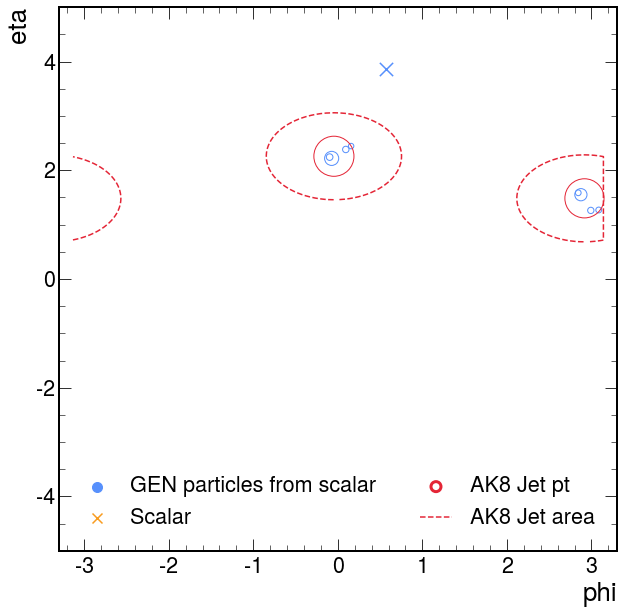

nGenParts = 78.000

nGenParts = 78.000

nGenParts = 10.000

nMuon = 7.000

nGenMuon = 6.000

sph = 0.257

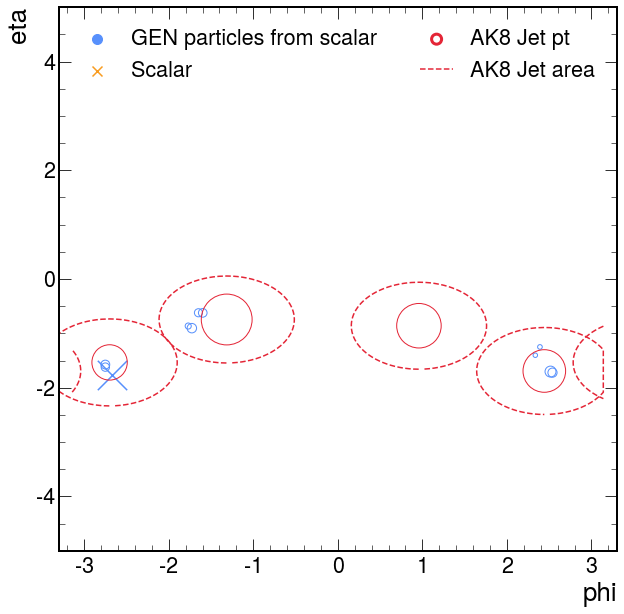

nGenParts = 38.000

nGenParts = 38.000

nGenParts = 8.000

nMuon = 6.000

nGenMuon = 6.000

sph = 0.101

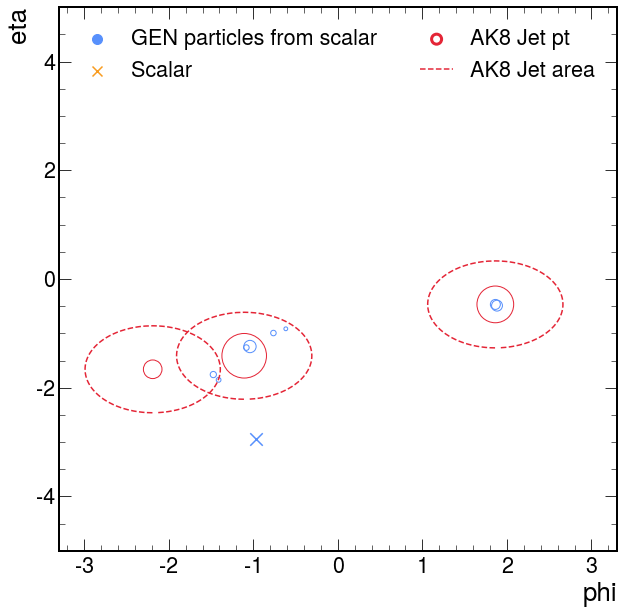

nGenParts = 21.000

nGenParts = 21.000

nGenParts = 8.000

nMuon = 7.000

nGenMuon = 8.000

sph = 0.099

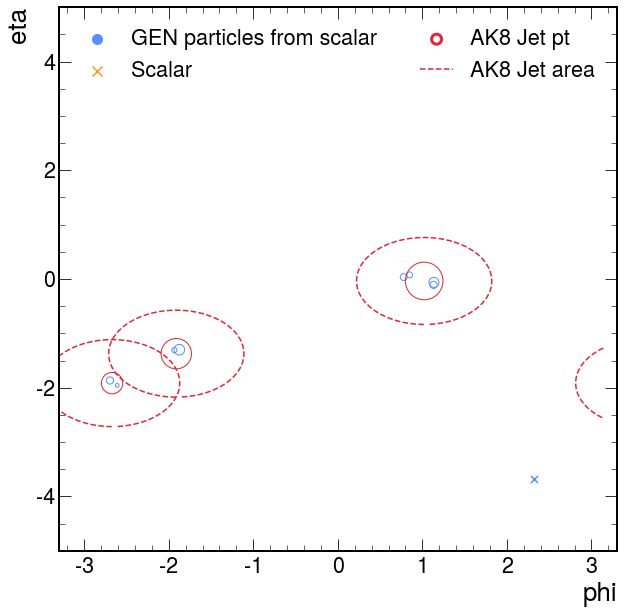

In [94]:
iEvt = 1
for iEvt in range(4):
    plt.scatter(
        gen_parts_collection[iEvt].phi, gen_parts_collection[iEvt].eta, s=5*gen_parts_collection[iEvt].pt, 
        facecolors='none', edgecolors='C0'
    )
    plt.scatter(scalar[iEvt].phi, scalar[iEvt].eta, s=10*scalar[iEvt].pt, marker='x')
    plt.scatter(
        ak8jets[iEvt].phi, ak8jets[iEvt].eta, s=30*ak8jets[iEvt].pt,
        facecolors='none', edgecolors='C2'
    )
    for jet in ak8jets[iEvt]:
        phis, etas = get_dr_ring(0.8, jet.phi, jet.eta)
        phis = phis[1:]
        etas = etas[1:]
        plt.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C2', linestyle='--')
        plt.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C2', linestyle='--')
        plt.plot(phis[phis<math.pi], etas[phis<math.pi], color='C2', linestyle='--')

    plt.xlim(-3.3, 3.3)
    plt.ylim(-5, 5)
    plt.xlabel('phi')
    plt.ylabel('eta')
    plt.scatter([], [], s=100, color='C0', label="GEN particles from scalar")
    plt.scatter([], [], s=100, color='C1', marker='x', label="Scalar")
    plt.scatter([], [], s=100, color='C2', facecolors='none', edgecolors='C2', lw=3, label="AK8 Jet pt")
    plt.plot([], [], color='C2', linestyle='--', label="AK8 Jet area")
    plt.legend(ncol=2)
    plt.show()

In [1]:
## For Jacob

In [2]:
import uproot
import awkward as ak
from coffea import nanoevents

def get_dr_ring(dr, phi_c=0, eta_c=0, n_points=600):
    """
    Function to get the phi, eta coordinates of the ring 
    around a jet centered at phi_c, eta_c.
    """
    deta = np.linspace(-dr, +dr, n_points)
    dphi = np.sqrt(dr**2 - np.square(deta))
    deta = eta_c+np.concatenate((deta, deta[::-1]))
    dphi = phi_c+np.concatenate((dphi, -dphi[::-1]))
    return dphi, deta

file = nanoevents.NanoEventsFactory.from_root(
    "some_file.root",
    schemaclass=nanoevents.NanoAODSchema,
)
events = file.events()

muons = events.Muon
events, muons = events[ak.num(muons) > 0], muons[ak.num(muons) > 0]
clean_muons = (
    (events.Muon.mediumId)
    & (events.Muon.pt > 3)
    & (abs(events.Muon.eta) < 2.4)
    & (abs(events.Muon.dxy) <= 0.02) 
    & (abs(events.Muon.dz) <= 0.1)
)
muons = muons[clean_muons]

# Get last Scalar (Higgs) particle in the decay chain
scalar = events.GenPart[(events.GenPart.pdgId==25) & (events.GenPart.status==62)]
scalar_collection = ak.zip(
    {
        "px": scalar.px,
        "py": scalar.py,
        "pz": scalar.pz,
        "mass": scalar.mass,
    },
    with_name="Momentum4D",
)
scalar_collection = ak.flatten(scalar_collection)

jets = events.Jet[events.Jet.pt > 20 & abs(events.Jet.eta) < 2.5]

# Number of event in the file to plot
iEvt = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(muons[iEvt].phi, muons[iEvt].eta, s=30*muons[iEvt].pt)
ax.scatter(events.Electron[iEvt].phi, events.Electron[iEvt].eta, s=30*events.Electron[iEvt].pt)
ax.scatter(scalar[iEvt].phi, scalar[iEvt].eta, s=30*scalar[iEvt].pt, marker='x')
ax.scatter(
    jets[iEvt].phi, jets[iEvt].eta, s=30*jets[iEvt].pt,
    facecolors='none', edgecolors='C4', lw=3
)

for jet in jets[iEvt]:
    phis, etas = get_dr_ring(0.4, jet.phi, jet.eta)
    ax.plot(phis[phis>math.pi]-2*math.pi, etas[phis>math.pi], color='C4', linestyle='--')
    ax.plot(phis[phis<-math.pi]+2*math.pi, etas[phis<-math.pi], color='C4', linestyle='--')
    ax.plot(phis[phis<math.pi], etas[phis<math.pi], color='C4', linestyle='--')

ax.text(-3, -4.5, "Cuts:\n    Trigger && \n    some other cut")

ax.set_xlim(-3.3, 3.3)
ax.set_ylim(-5, 5)
ax.set_xlabel('phi')
ax.set_ylabel('eta')
ax.scatter([], [], s=100, color='C0', label="PFCands")
ax.scatter([], [], s=100, color='C1', label="Muons")
ax.scatter([], [], s=100, color='C2', label="Electrons")
ax.scatter([], [], s=100, color='C3', marker='x', label="Scalar")
ax.scatter([], [], s=100, color='C4', facecolors='none', edgecolors='C4', lw=3, label="AK8 Jet pt")
ax.plot([], [], color='C4', linestyle='--', label="AK8 Jet area")
ax.legend(ncol=2, loc=1)
fig.tight_layout()
# Uncomment below to save the file
# fig.savefig(f"output_path/evt_{iEvt}_display.pdf")
plt.show()

FileNotFoundError: file not found

    'some_file.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.
